In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt #To plot the reduction in error
import sklearn # To plot ROC
from sklearn import metrics #To plot confusion matrix
import seaborn as sns #Heat map used for confusion matrix
from mnist import MNIST # To unload the ubyte data - Image data set
import itertools
import time

In [2]:
# Load the data set
mndata = MNIST('samples')
images1, labels1 = mndata.load_training()
# or
images2, labels2 = mndata.load_testing()

In [3]:
train = pd.DataFrame(images1)
train['Target'] = labels1
test = pd.DataFrame(images2)
test['Target'] = labels2

In [4]:
train = train.loc[(train['Target'] == 3) | (train['Target'] == 9)]
test = test.loc[(test['Target'] == 3) | (test['Target'] == 9)]

In [5]:
train_y = train["Target"]
train_x = train.drop(['Target'], axis=1).as_matrix()
test_y = test["Target"]
test_x = test.drop(['Target'], axis=1).as_matrix()
train_x = sklearn.preprocessing.normalize(train_x, norm='max')
test_x = sklearn.preprocessing.normalize(test_x, norm='max')

In [6]:
# Converting to numpy array
train_y = np.asarray(train_y).reshape(len(train_y), 1)
test_y = np.asarray(test_y).reshape(len(test_y), 1)
train_y = np.where(train_y == 3, 0, 1).reshape(len(train_y), 1)
test_y = np.where(test_y == 3, 0, 1).reshape(len(test_y), 1)

In [7]:
train_x = train_x[:7000]
train_y = train_y[:7000]
test_x = test_x[:1000]
test_y = test_y[:1000]

In [36]:
#0.0009 and 200, 0.005
class NeuralNet():
    def __init__(self, train_x, train_y, test_x, 
                 test_y, hidden_layers = 2, hidden_node = 200, learning_rate=0.0009, epoch=70, regParam=0.005):
        self.op_node = 1
        self.learning_rate= learning_rate
        self.hidden_node = hidden_node
        self.hidden_layers = hidden_layers
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.input_node = train_x.shape[1]
        self.epoch = epoch
        self.train_predict = None
        self.error = None
        self.test_predict = None
        self.regParam = regParam
        self.rmse = None
        self.root_mse = None
        self.t = None


        # Initialising Random Weights
        if self.hidden_layers == 1:
            self.w1_ly1 = np.random.randn(self.input_node, self.hidden_node)
            self.b1_ly1 = np.zeros((1, self.hidden_node))
            self.w2_ly2 = np.random.randn(self.hidden_node, self.op_node)
            self.b2_ly2 = np.zeros((1, self.op_node))
        
        if self.hidden_layers == 2:
            self.w1_ly1 = np.random.randn(self.input_node, self.hidden_node)
            self.b1_ly1 = np.zeros((1, self.hidden_node))
            self.w2_ly2 = np.random.randn(self.hidden_node, self.hidden_node)
            self.b2_ly2 = np.zeros((1, self.hidden_node))
            self.w3_ly3 = np.random.randn(self.hidden_node, self.op_node)
            self.b3_ly3 = np.zeros((1, self.op_node))
            
            
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
        
    
    def gradient_descent(self, tdelta1, tdelta2, tb1, tb2, tdelta3=0, tb3=0):
        if self.hidden_layers == 1:
            self.w1_ly1 = self.w1_ly1 - self.learning_rate*(tdelta1 + (self.regParam * self.w1_ly1))
            self.w2_ly2 = self.w2_ly2 - self.learning_rate*(tdelta2 + (self.regParam * self.w2_ly2))
            self.b1_ly1 = self.b1_ly1 - self.learning_rate*tb1
            self.b2_ly2 = self.b2_ly2 - self.learning_rate*tb2
            
        if self.hidden_layers == 2:
            self.w1_ly1 = self.w1_ly1 - self.learning_rate*(tdelta1 + (self.regParam * self.w1_ly1))
            self.w2_ly2 = self.w2_ly2 - self.learning_rate*(tdelta2 + (self.regParam * self.w2_ly2))
            self.w3_ly3 = self.w3_ly3 - self.learning_rate*(tdelta3 + (self.regParam * self.w3_ly3))
            self.b1_ly1 = self.b1_ly1 - self.learning_rate*tb1
            self.b2_ly2 = self.b2_ly2 - self.learning_rate*tb2
            self.b3_ly3 = self.b3_ly3 - self.learning_rate*tb3
            
    def adam_gradient_descent(self, vdw1, vdw2, vdw3, vb1, vb2, vb3, sdw1, sdw2, sdw3, sb1, sb2, sb3):
        epsilon = 0.0000001
        if self.hidden_layers ==2:
            self.w1_ly1 = self.w1_ly1 - self.learning_rate*(vdw1/np.sqrt(sdw1+epsilon))
            self.w2_ly2 = self.w2_ly2 - self.learning_rate*(vdw2/np.sqrt(sdw2+epsilon))
            self.w3_ly3 = self.w3_ly3 - self.learning_rate*(vdw3/np.sqrt(sdw3+epsilon))
            self.b1_ly1 = self.b1_ly1 - self.learning_rate*(vb1/np.sqrt(sb1+epsilon))
            self.b2_ly2 = self.b2_ly2 - self.learning_rate*(vb2/np.sqrt(sb2+epsilon))
            self.b3_ly3 = self.b3_ly3 - self.learning_rate*(vb3/np.sqrt(sb3+epsilon))
        
        
        
    def trainNN(self):
        rmse = []
        root_mse = []
        
        for ep in range(self.epoch):
            s = 0
            error = []
            act_func = []
            self.t = 1
            vdw1 = 0
            vdw2 = 0
            vdw3 = 0
            sdw1 = 0
            sdw2 = 0
            sdw3 = 0
            vb1 = 0
            vb2 = 0
            vb3 = 0
            sb1 = 0
            sb2 = 0
            sb3 = 0
            beta1 = 0.9
            beta2 = 0.999
            
            
            for batch in [1000, 2000, 3000, 4000, 5000, 6000, 7000]:
                train_x = self.train_x[s:batch]
                train_y = self.train_y[s:batch]
                #print(s)
                s=s+len(train_x)
                
                if self.hidden_layers == 1:
                    #Forward Feed
                    a1 = train_x
                    z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                    a2 = self.activation(z2)
                    z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                    a3 = self.activation(z3)
                    er = a3 - train_y
                    error.append(er)

                    #Backward propogation
                    delta2 = er*a3*(1-a3)  # a3*(1-a3) is same as derivative of sigmoid finction
                    delta1 = np.dot(delta2, self.w2_ly2.T)*a2*(1 - a2)
                    tdelta2 = np.dot(a2.T, delta2)
                    tdelta1 = np.dot(train_x.T, delta1)
                    tb2 = np.sum(delta2, axis=0).reshape(1, self.op_node)
                    tb1 = np.sum(delta1,axis=0).reshape(1, self.hidden_node)
                    self.gradient_descent(tdelta1, tdelta2, tb1, tb2)
                    act_func.append(a3)

                if self.hidden_layers == 2:
                    #Forward Propogation
                    a1 = train_x
                    z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                    a2 = self.activation(z2)
                    z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                    a3 = self.activation(z3)
                    z4 = np.dot(a3, self.w3_ly3) + self.b3_ly3
                    a4 = self.activation(z4)
                    er = a4 - train_y
                    error.append(er)

                    #Backward propogation
                    delta3 = er*a4*(1-a4)
                    delta2 = np.dot(delta3, self.w3_ly3.T)*a3*(1 - a3)
                    delta1 = np.dot(delta2, self.w2_ly2.T)*a2*(1 - a2)
                    tdelta3 = np.dot(a3.T, delta3)
                    tdelta2 = np.dot(a2.T, delta2)
                    tdelta1 = np.dot(train_x.T, delta1)
                    tb3 = np.sum(delta3, axis=0).reshape(1, self.op_node)
                    tb2 = np.sum(delta2,axis=0).reshape(1, self.hidden_node)
                    tb1 = np.sum(delta1,axis=0).reshape(1, self.hidden_node)
                    #self.gradient_descent(tdelta1, tdelta2, tb1, tb2, tdelta3, tb3)
                    act_func.append(a4)
                    
                    self.t = self.t+1
                    vdw1 = ((vdw1*beta1)+((1-beta1)*tdelta1))/(1-beta1**self.t)
                    vdw2 = ((vdw2*beta1)+((1-beta1)*tdelta2))/(1-beta1**self.t)
                    vdw3 = ((vdw3*beta1)+((1-beta1)*tdelta3))/(1-beta1**self.t)
                    vb1 = ((vb1*beta1)+((1-beta1)*tb1))/(1-beta1**self.t)
                    vb2 = ((vb2*beta1)+((1-beta1)*tb2))/(1-beta1**self.t)
                    vb3 = ((vb3*beta1)+((1-beta1)*tb3))/(1-beta1**self.t)
                    sdw1 = ((sdw1*beta2)+((1-beta2)*np.square(tdelta1)))/(1-beta2**self.t)
                    sdw2 = ((sdw2*beta2)+((1-beta2)*np.square(tdelta2)))/(1-beta2**self.t)
                    sdw3 = ((sdw3*beta2)+((1-beta2)*np.square(tdelta3)))/(1-beta2**self.t)
                    sb1 = ((sb1*beta2)+((1-beta2)*np.square(tb1)))/(1-beta2**self.t)
                    sb2 = ((sb2*beta2)+((1-beta2)*np.square(tb2)))/(1-beta2**self.t)
                    sb3 = ((sb3*beta2)+((1-beta2)*np.square(tb3)))/(1-beta2**self.t)
                    self.adam_gradient_descent(vdw1, vdw2, vdw3, vb1, vb2, vb3, sdw1, sdw2, sdw3, sb1, sb2, sb3)
                    
                    
            act_func = list(itertools.chain.from_iterable(act_func))
            error = list(itertools.chain.from_iterable(error))
            act_func = np.asarray(act_func).reshape(len(act_func), 1)
            error = np.asarray(error).reshape(len(error), 1)
            mean_error = np.sum(error)/len(error)
            rmse.append(mean_error)
            root_error = np.sqrt(np.sum(error**2)/len(error))
            root_mse.append(root_error)
            self.error = np.asarray(error)
            self.train_predict = np.asarray(act_func)
            
            if ep in [1, 4, 6, 10, 20, 30, 40, 50, 60, 65, 69]:
                accuracy = 1-np.sum(abs(np.asarray(error)))/len(np.asarray(error))
                print("Accuracy is:  {0:.4f}, for epoch:{1}".format(accuracy, ep))
            #break
                    
        self.rmse = rmse
        self.root_mse = root_mse
        
        
    def predict_digit(self):
        
        if self.hidden_layers == 1:
                #Forward Feed
                a1 = self.test_x
                z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                a2 = self.activation(z2)
                z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                a3 = self.activation(z3)
                
                self.test_predict = np.round(a3)
        
        if self.hidden_layers == 2:
                #Forward Propogation
                a1 = self.test_x
                z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                a2 = self.activation(z2)
                z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                a3 = self.activation(z3)
                z4 = np.dot(a3, self.w3_ly3) + self.b3_ly3
                a4 = self.activation(z4)
                
                self.test_predict = np.round(a4)

Accuracy is:  0.5001, for epoch:1
Accuracy is:  0.5228, for epoch:4
Accuracy is:  0.5601, for epoch:6
Accuracy is:  0.6723, for epoch:10
Accuracy is:  0.8528, for epoch:20
Accuracy is:  0.9162, for epoch:30
Accuracy is:  0.9401, for epoch:40
Accuracy is:  0.9518, for epoch:50
Accuracy is:  0.9614, for epoch:60
Accuracy is:  0.9652, for epoch:65
Accuracy is:  0.9674, for epoch:69


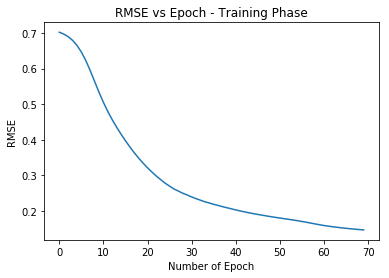

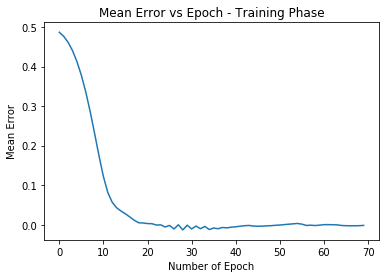

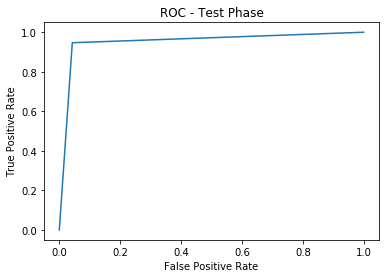

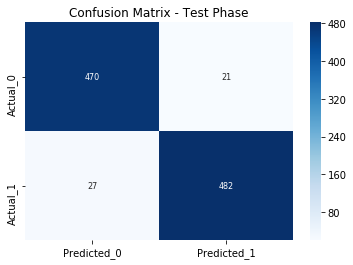

Test Accuracy:  0.952
Elapsed Time For Training is:  37.929789304733276


In [37]:
start_time = time.time()
new = NeuralNet(train_x, train_y, test_x, test_y)
new.trainNN()
new.predict_digit()

plt.plot(new.root_mse)
plt.title("RMSE vs Epoch - Training Phase")
plt.xlabel("Number of Epoch")
plt.ylabel("RMSE")
plt.show()


plt.plot(new.rmse)
plt.title("Mean Error vs Epoch - Training Phase")
plt.xlabel("Number of Epoch")
plt.ylabel("Mean Error")
plt.show()


fpr, tpr, thresholds = sklearn.metrics.roc_curve(new.test_y, new.test_predict, 
                                                 pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr)
plt.title("ROC - Test Phase")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

ax=plt.axes()
arr = metrics.confusion_matrix(new.test_y, new.test_predict, sample_weight=None)
con_df = pd.DataFrame(arr, columns = ["Predicted_0", "Predicted_1"], index=["Actual_0", "Actual_1"])
sns.heatmap(con_df, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - Test Phase')
plt.show()

print('Test Accuracy: ', 1-np.sum(abs(new.test_y - new.test_predict))/len(new.test_predict))
elapsed_time = time.time() - start_time
print("Elapsed Time For Training is: ", elapsed_time)